In [3]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [6]:
df=pd.read_csv('GE.csv')
print(df.head())

         Date        Open        High         Low       Close   Adj Close  \
0  2021-06-03  111.919998  114.959999  111.519997  112.720001  112.347389   
1  2021-06-04  113.279999  113.599998  110.879997  111.680000  111.310829   
2  2021-06-07  112.000000  112.559998  110.879997  111.279999  110.912148   
3  2021-06-08  111.760002  111.919998  109.760002  111.199997  110.832405   
4  2021-06-09  110.160004  110.480003  109.360001  109.839996  109.476906   

    Volume  
0  7895475  
1  8008900  
2  4668638  
3  5515250  
4  6970963  


In [24]:
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15))

238   2022-05-12
239   2022-05-13
240   2022-05-16
241   2022-05-17
242   2022-05-18
243   2022-05-19
244   2022-05-20
245   2022-05-23
246   2022-05-24
247   2022-05-25
248   2022-05-26
249   2022-05-27
250   2022-05-31
251   2022-06-01
252   2022-06-02
Name: Date, dtype: datetime64[ns]


In [25]:
cols = list(df)[1:6]


In [26]:
print(cols)

['Open', 'High', 'Low', 'Close', 'Adj Close']


In [27]:
df_for_training = df[cols].astype(float)

In [28]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [29]:
trainX = []
trainY = []

In [31]:
n_future = 1
n_past = 14 

In [32]:
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (239, 14, 5).
trainY shape == (239, 1).


In [33]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 64)            17920     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
14/14 [==============================] - 5s 221ms/step - loss: 0.4589 - val_loss: 29.3620
Epoch 2/5
14/14 [==============================] - 1s 58ms/step - loss: 0.1612 - val_loss: 70.4323
Epoch 3/5
14/14 [==============================] - 1s 61ms/step - loss: 0.1578 - val_loss: 24.7311
Epoch 4/5
14/14 [==============================] - 1s 63ms/step - loss: 0.1340 - val_loss: 35.4064
Epoch 5/5
14/14 [==============================] - 1s 65ms/step - loss: 0.1410 - val_loss: 48.4364


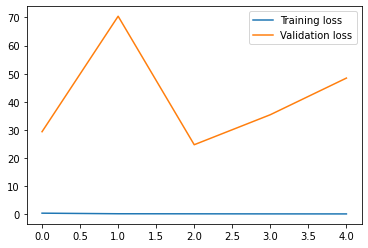

In [34]:
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [35]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

In [36]:
n_past = 16
n_days_for_prediction=15

In [37]:
predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)

[Timestamp('2022-05-11 00:00:00', freq='C'), Timestamp('2022-05-12 00:00:00', freq='C'), Timestamp('2022-05-13 00:00:00', freq='C'), Timestamp('2022-05-16 00:00:00', freq='C'), Timestamp('2022-05-17 00:00:00', freq='C'), Timestamp('2022-05-18 00:00:00', freq='C'), Timestamp('2022-05-19 00:00:00', freq='C'), Timestamp('2022-05-20 00:00:00', freq='C'), Timestamp('2022-05-23 00:00:00', freq='C'), Timestamp('2022-05-24 00:00:00', freq='C'), Timestamp('2022-05-25 00:00:00', freq='C'), Timestamp('2022-05-26 00:00:00', freq='C'), Timestamp('2022-05-27 00:00:00', freq='C'), Timestamp('2022-05-31 00:00:00', freq='C'), Timestamp('2022-06-01 00:00:00', freq='C')]


In [38]:
prediction = model.predict(trainX[-n_days_for_prediction:])

In [39]:
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [40]:
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']

C:\Users\2109902\AppData\Local\Temp\ipykernel_4256\758288046.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])
